In [1]:
!pip install transformers diffusers ftfy accelerate

In [27]:
import os
import torch
from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms as tfms
from transformers import CLIPTextModel, CLIPTokenizer, logging
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel

In [3]:
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

In [4]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

In [6]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [7]:
# Access the embedding layer
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
token_emb_layer # Vocab size 49408, emb_dim 768

Embedding(49408, 768)

In [8]:
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
pos_emb_layer

Embedding(77, 768)

In [9]:
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)
print(position_embeddings.shape)
position_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0016,  0.0020,  0.0002,  ..., -0.0013,  0.0008,  0.0015],
         [ 0.0042,  0.0029,  0.0002,  ...,  0.0010,  0.0015, -0.0012],
         [ 0.0018,  0.0007, -0.0012,  ..., -0.0029, -0.0009,  0.0026],
         ...,
         [ 0.0216,  0.0055, -0.0101,  ..., -0.0065, -0.0029,  0.0037],
         [ 0.0188,  0.0073, -0.0077,  ..., -0.0025, -0.0009,  0.0057],
         [ 0.0330,  0.0281,  0.0289,  ...,  0.0160,  0.0102, -0.0310]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

In [10]:
def build_causal_attention_mask(bsz, seq_len, dtype):
    mask = torch.empty(bsz, seq_len, seq_len, dtype=dtype)
    mask.fill_(torch.tensor(torch.finfo(dtype).min))  # fill with large negative number (acts like -inf)
    mask = mask.triu_(1)  # zero out the lower diagonal to enforce causality
    return mask.unsqueeze(1)  # add a batch dimension

In [11]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

In [12]:
def generate_with_embs(text_embeddings):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

In [13]:
concept_art_embed = torch.load('concept-art.bin')
concept_art_embed.keys(), concept_art_embed['<concept-art>'].shape

(dict_keys(['<concept-art>']), torch.Size([768]))

In [14]:
doose_s_realistic_art_style_embed = torch.load('doose-s-realistic-art-style.bin')
doose_s_realistic_art_style_embed.keys(), doose_s_realistic_art_style_embed['<doose-realistic>'].shape

(dict_keys(['<doose-realistic>']), torch.Size([768]))

In [15]:
line_art_embed = torch.load('line-art.bin')
line_art_embed.keys(), line_art_embed['<line-art>'].shape

(dict_keys(['<line-art>']), torch.Size([768]))

In [16]:
rickyart_embed = torch.load('rickyart.bin')
rickyart_embed.keys(), rickyart_embed['<RickyArt>'].shape

(dict_keys(['<RickyArt>']), torch.Size([768]))

In [17]:
tony_diterlizzi_s_planescape_art_embed = torch.load('tony-diterlizzi-s-planescape-art.bin')
tony_diterlizzi_s_planescape_art_embed.keys(), tony_diterlizzi_s_planescape_art_embed['<tony-diterlizzi-planescape>'].shape

(dict_keys(['<tony-diterlizzi-planescape>']), torch.Size([768]))

In [18]:
tokenizer.add_tokens(['<concept-art>', '<doose-realistic>', '<line-art>', '<RickyArt>', '<tony-diterlizzi-planescape>'])

5

In [19]:
token_emb_layer.state_dict()['weight'].size()

torch.Size([49408, 768])

In [20]:
token_emb_layer_with_art = torch.nn.Embedding(49413, 768)
token_emb_layer_with_art.load_state_dict({'weight': torch.cat((token_emb_layer.state_dict()['weight'],
                                              concept_art_embed['<concept-art>'].unsqueeze(0).to(torch_device),
                                              doose_s_realistic_art_style_embed['<doose-realistic>'].unsqueeze(0).to(torch_device),
                                              line_art_embed['<line-art>'].unsqueeze(0).to(torch_device),
                                              rickyart_embed['<RickyArt>'].unsqueeze(0).to(torch_device),
                                              tony_diterlizzi_s_planescape_art_embed['<tony-diterlizzi-planescape>'].unsqueeze(0).to(torch_device)))})
token_emb_layer_with_art = token_emb_layer_with_art.to(torch_device)

In [21]:
token_emb_layer_with_art.state_dict()['weight'].size()

torch.Size([49413, 768])

In [22]:
prompt = 'A mouse in the style of <concept-art>'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer_with_art(input_ids)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
generate_with_embs(modified_output_embeddings)

In [23]:
grayscale_transformer = tfms.Grayscale(num_output_channels=3)

In [28]:
def guide_loss(images, loss_type='grayscale'):
    # grayscale loss
    if loss_type == 'grayscale':
      transformed_imgs = grayscale_transformer(images)
      error = torch.abs(transformed_imgs - images).mean()

    # brightness loss
    elif loss_type == 'bright':
      transformed_imgs = tfms.functional.adjust_brightness(images, brightness_factor=3)
      error = torch.abs(transformed_imgs - images).mean()

    # contrast loss
    elif loss_type == 'contrast':
      transformed_imgs = tfms.functional.adjust_contrast(images, contrast_factor=10)
      error = torch.abs(transformed_imgs - images).mean()

    # symmetry loss - Flip the image along the width
    elif loss_type == "symmetry":
      flipped_image = torch.flip(images, [3])
      error = F.mse_loss(images, flipped_image)

    # saturation loss
    elif loss_type == 'saturation':
      transformed_imgs = tfms.functional.adjust_saturation(images,saturation_factor = 10)
      error = torch.abs(transformed_imgs - images).mean()

    return error

<ipython-input-30-adb28f4d02ed>:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
  2%|▏         | 1/50 [00:01<00:51,  1.05s/it]

0 loss: 53.81732177734375


 22%|██▏       | 11/50 [00:08<00:33,  1.18it/s]

10 loss: 30.75804328918457


 42%|████▏     | 21/50 [00:15<00:23,  1.21it/s]

20 loss: 25.744983673095703


 62%|██████▏   | 31/50 [00:22<00:17,  1.11it/s]

30 loss: 23.00574493408203


 82%|████████▏ | 41/50 [00:30<00:08,  1.08it/s]

40 loss: 22.608488082885742


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


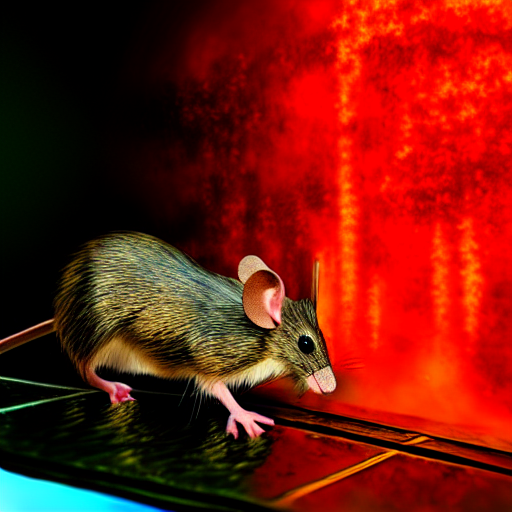

In [30]:
prompt = 'A mouse in the style of <concept-art>'
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50        # Number of denoising steps
guidance_scale = 8           # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1
loss_scale = 200

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, modified_output_embeddings])

# Prep Scheduler
set_timesteps(scheduler, num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

# Loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #### ADDITIONAL GUIDANCE ###
    if i%5 == 0:
        # Requires grad on the latents
        latents = latents.detach().requires_grad_()

        # Get the predicted x0:
        latents_x0 = latents - sigma * noise_pred
        # latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

        # Decode to image space
        denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

        # Calculate loss
        loss = guide_loss(denoised_images, 'saturation') * loss_scale

        # Occasionally print it out
        if i%10==0:
            print(i, 'loss:', loss.item())

        # Get gradient
        cond_grad = torch.autograd.grad(loss, latents)[0]

        # Modify the latents based on this gradient
        latents = latents.detach() - cond_grad * sigma**2

    # Now step with scheduler
    latents = scheduler.step(noise_pred, t, latents).prev_sample


latents_to_pil(latents)[0]